In [1]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
# General imports

import matplotlib.pyplot as plt
import os
import random
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers

In [ ]:
!wget https://mmlab.ie.cuhk.edu.hk/archive/cufsf/files/original_sketch.zip
!unzip original_sketch.zip

In [5]:
# prompt: convert images in original_sketch folder into a list of images split it between training and testing data


# im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)

# Get a list of all files in the directory
files = os.listdir('original_sketch')

# Load all images into a list
images = []
for file in files:
  img = cv2.imread(os.path.join('original_sketch', file))
  im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  im_gray = cv2.resize(im_gray, (28,28), interpolation = cv2.INTER_AREA)

  images.append(im_gray)

# images = np.array(images) # convert the list to a NumPy array

# Split the images into training and testing sets
x_train, x_test = train_test_split(images, test_size=0.2)

X_train = np.stack(x_train, axis=0)
X_test = np.stack(x_test, axis=0)


X_train = X_train.astype('float32') / 127.5 - 1
X_test = X_test.astype('float32') / 127.5 - 1

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

x_train = X_train
x_test = X_test


In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Define the hyperparameters
latent_dim = 100 # the dimension of the latent space
batch_size = 64 # the size of the mini-batches
epochs = 50 # the number of training epochs
learning_rate = 0.0002 # the learning rate for the optimizer
beta_1 = 0.5 # the beta_1 parameter for the optimizer

# Define the generator model
def generator_model():
  # Create a sequential model
  model = keras.Sequential()
  # Add a dense layer that takes the latent vector as input and outputs a 7x7x256 tensor
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)))
  # Add a batch normalization layer
  model.add(layers.BatchNormalization())
  # Add a ReLU activation layer
  model.add(layers.ReLU())
  # Reshape the output to a 7x7x256 tensor
  model.add(layers.Reshape((7, 7, 256)))
  # Add a convolutional transpose layer that outputs a 14x14x128 tensor
  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  # Add a batch normalization layer
  model.add(layers.BatchNormalization())
  # Add a ReLU activation layer
  model.add(layers.ReLU())
  # Add another convolutional transpose layer that outputs a 28x28x64 tensor
  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  # Add a batch normalization layer
  model.add(layers.BatchNormalization())
  # Add a ReLU activation layer
  model.add(layers.ReLU())
  # Add a final convolutional transpose layer that outputs a 28x28x1 tensor
  model.add(layers.Conv2DTranspose(1, (5, 5), padding='same', use_bias=False, activation='tanh'))
  # Return the model
  return model

# Define the discriminator model
def discriminator_model():
  # Create a sequential model
  model = keras.Sequential()
  # Add a convolutional layer that takes a 28x28x1 image as input and outputs a 14x14x64 tensor
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  # Add a LeakyReLU activation layer with alpha=0.2
  model.add(layers.LeakyReLU(0.2))
  # Add another convolutional layer that outputs a 7x7x128 tensor
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  # Add a batch normalization layer
  model.add(layers.BatchNormalization())
  # Add a LeakyReLU activation layer with alpha=0.2
  model.add(layers.LeakyReLU(0.2))
  # Flatten the output
  model.add(layers.Flatten())
  # Add a dense layer that outputs a scalar
  model.add(layers.Dense(1))
  # Return the model
  return model

# Create the generator and the discriminator
generator = generator_model()
discriminator = discriminator_model()

# Define the binary cross-entropy loss function
bce = keras.losses.BinaryCrossentropy(from_logits=True)

# Define the discriminator loss function
def discriminator_loss(real_output, fake_output):
  # Compute the loss for the real images
  real_loss = bce(tf.ones_like(real_output), real_output)
  # Compute the loss for the fake images
  fake_loss = bce(tf.zeros_like(fake_output), fake_output)
  # Return the total loss
  return real_loss + fake_loss

# Define the generator loss function
def generator_loss(fake_output):
  # Compute the loss for the fake images
  return bce(tf.ones_like(fake_output), fake_output)

# Define the optimizers for the generator and the discriminator
generator_optimizer = keras.optimizers.Adam(learning_rate, beta_1)
discriminator_optimizer = keras.optimizers.Adam(learning_rate, beta_1)

# Define a function to generate and save images
def generate_and_save_images(model, epoch, test_input):
  # Generate images from the test input
  predictions = model(test_input, training=False)
  # Plot the images in a 4x4 grid
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  # Save the figure
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size)

# Create a random vector to test the generator
test_input = tf.random.normal([16, latent_dim])

# Define the training loop
@tf.function
def train_step(images):
  # Generate random noise
  noise = tf.random.normal([batch_size, latent_dim])
  # Use GradientTape to record the gradients
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Generate fake images using the generator
    generated_images = generator(noise, training=True)
    # Classify the real and fake images using the discriminator
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    # Compute the generator and discriminator losses
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  # Compute the gradients for the generator and the discriminator
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  # Apply the gradients to the optimizer
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss, disc_loss
# Train the DCGAN
# Initialize lists to store the losses
gen_losses = []
disc_losses = []

for epoch in range(epochs):
  # Loop over the batches
  for image_batch in train_dataset:
    # Train the model on the current batch
    gen_loss, disc_loss = train_step(image_batch)

  # Append the losses to the lists
  gen_losses.append(gen_loss)
  disc_losses.append(disc_loss)

  # Generate and save images at the end of each epoch
  generate_and_save_images(generator, epoch + 1, test_input)
  # Print the current epoch
  print ('Epoch {} done'.format(epoch + 1))

# Plot the losses
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Generate and save the final images
generate_and_save_images(generator, epochs, test_input)


In [ ]:
# prompt: given gen_loss and disc_loss in each iteration plot both loses against number of iterations

# Initialize lists to store the losses
gen_losses = []
disc_losses = []

# Loop over the epochs
for epoch in range(epochs):
  # Loop over the batches
  for image_batch in train_dataset:
    # Train the model on the current batch
    gen_loss, disc_loss = train_step(image_batch)
    # Append the losses to the lists
    gen_losses.append(gen_loss)
    disc_losses.append(disc_loss)

# Plot the losses
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Higher resolution



In [7]:
# prompt: convert images in original_sketch folder into a list of images split it between training and testing data


# im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)

# Get a list of all files in the directory
files = os.listdir('original_sketch')

# Load all images into a list
images = []
for file in files:
  img = cv2.imread(os.path.join('original_sketch', file))
  im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  im_gray = cv2.resize(im_gray, (128,128), interpolation = cv2.INTER_AREA)

  images.append(im_gray)

# images = np.array(images) # convert the list to a NumPy array

# Split the images into training and testing sets
x_train, x_test = train_test_split(images, test_size=0.2)

X_train = np.stack(x_train, axis=0)
X_test = np.stack(x_test, axis=0)


X_train = X_train.astype('float32') / 127.5 - 1
X_test = X_test.astype('float32') / 127.5 - 1

X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)

x_train = X_train
x_test = X_test

In [30]:

# Define the hyperparameters
latent_dim = 100 # the dimension of the latent space
batch_size = 64 # the size of the mini-batches
epochs = 50 # the number of training epochs
learning_rate = 0.0002 # the learning rate for the optimizer
beta_1 = 0.5 # the beta_1 parameter for the optimizer
# Define the generator model
def generator_model():
  # Create a sequential model
  model = keras.Sequential()
  # Add a dense layer that takes the latent vector as input and outputs a 8x8x256 tensor
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(latent_dim,)))
  # Add a batch normalization layer
  model.add(layers.BatchNormalization())
  # Add a ReLU activation layer
  model.add(layers.ReLU())
  # Reshape the output to a 8x8x256 tensor
  model.add(layers.Reshape((8, 8, 256)))
  # Add a convolutional transpose layer that outputs a 16x16x128 tensor
  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  # Add a batch normalization layer
  model.add(layers.BatchNormalization())
  # Add a ReLU activation layer
  model.add(layers.ReLU())
  # Add another convolutional transpose layer that outputs a 32x32x64 tensor
  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  # Add a batch normalization layer
  model.add(layers.BatchNormalization())
  # Add a ReLU activation layer
  model.add(layers.ReLU())
  # Add another convolutional transpose layer that outputs a 64x64x32 tensor
  model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  # Add a batch normalization layer
  model.add(layers.BatchNormalization())
  # Add a ReLU activation layer
  model.add(layers.ReLU())
  # Add another convolutional transpose layer that outputs a 128x128x16 tensor
  model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  # Add a batch normalization layer
  model.add(layers.BatchNormalization())
  # Add a ReLU activation layer
  model.add(layers.ReLU())
  #Add a final convolutional transpose layer that outputs a 128x128x1 tensor
  model.add(layers.Conv2DTranspose(1, (5, 5), padding='same', use_bias=False, activation='tanh'))
  # Return the model
  return model

# Define the discriminator model
def discriminator_model():
  # Create a sequential model
  model = keras.Sequential()
  # Add a convolutional layer that takes a 128x128x1 image as input and outputs a 64x64x32 tensor
  model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 1]))
  # Add a LeakyReLU activation layer with alpha=0.2
  model.add(layers.LeakyReLU(0.2))
  # Add another convolutional layer that outputs a 32x32x64 tensor
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
  # Add a batch normalization layer
  model.add(layers.BatchNormalization())
  # Add a LeakyReLU activation layer with alpha=0.2
  model.add(layers.LeakyReLU(0.2))
  # Add another convolutional layer that outputs a 16x16x128 tensor
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  # Add a batch normalization layer
  model.add(layers.BatchNormalization())
  # Add a LeakyReLU activation layer with alpha=0.2
  model.add(layers.LeakyReLU(0.2))
  # Add another convolutional layer that outputs a 8x8x256 tensor
  model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
  # Add a batch normalization layer
  model.add(layers.BatchNormalization())
  # Add a LeakyReLU activation layer with alpha=0.2
  model.add(layers.LeakyReLU(0.2))
  # Flatten the output
  model.add(layers.Flatten())
  # Add a dense layer that outputs a scalar
  model.add(layers.Dense(1))
  # Return the model
  return model

# # Define the generator model
# def generator_model():
#   # Create a sequential model
#   model = keras.Sequential()
#   # Add a dense layer that takes the latent vector as input and outputs a 7x7x256 tensor
#   model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)))
#   # Add a batch normalization layer
#   model.add(layers.BatchNormalization())
#   # Add a ReLU activation layer
#   model.add(layers.ReLU())
#   # Reshape the output to a 7x7x256 tensor
#   model.add(layers.Reshape((7, 7, 256)))
#   # Add a convolutional transpose layer that outputs a 14x14x128 tensor
#   model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#   # Add a batch normalization layer
#   model.add(layers.BatchNormalization())
#   # Add a ReLU activation layer
#   model.add(layers.ReLU())
#   # Add another convolutional transpose layer that outputs a 28x28x64 tensor
#   model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#   # Add a batch normalization layer
#   model.add(layers.BatchNormalization())
#   # Add a ReLU activation layer
#   model.add(layers.ReLU())
#   # Add a final convolutional transpose layer that outputs a 28x28x1 tensor
#   model.add(layers.Conv2DTranspose(1, (5, 5), padding='same', use_bias=False, activation='tanh'))
#   # Return the model
#   return model

# # Define the discriminator model
# def discriminator_model():
#   # Create a sequential model
#   model = keras.Sequential()
#   # Add a convolutional layer that takes a 28x28x1 image as input and outputs a 14x14x64 tensor
#   model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 1]))
#   # Add a LeakyReLU activation layer with alpha=0.2
#   model.add(layers.LeakyReLU(0.2))
#   # Add another convolutional layer that outputs a 7x7x128 tensor
#   model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
#   # Add a batch normalization layer
#   model.add(layers.BatchNormalization())
#   # Add a LeakyReLU activation layer with alpha=0.2
#   model.add(layers.LeakyReLU(0.2))
#   # Flatten the output
#   model.add(layers.Flatten())
#   # Add a dense layer that outputs a scalar
#   model.add(layers.Dense(1))
#   # Return the model
#   return model

# Create the generator and the discriminator
generator = generator_model()
discriminator = discriminator_model()
# Define the binary cross-entropy loss function
bce = keras.losses.BinaryCrossentropy(from_logits=True)

# Define the discriminator loss function
def discriminator_loss(real_output, fake_output):
  # Compute the loss for the real images
  real_loss = bce(tf.ones_like(real_output), real_output)
  # Compute the loss for the fake images
  fake_loss = bce(tf.zeros_like(fake_output), fake_output)
  # Return the total loss
  return real_loss + fake_loss

# Define the generator loss function
def generator_loss(fake_output):
  # Compute the loss for the fake images
  return bce(tf.ones_like(fake_output), fake_output)

# Define the optimizers for the generator and the discriminator
generator_optimizer = keras.optimizers.Adam(learning_rate, beta_1)
discriminator_optimizer = keras.optimizers.Adam(learning_rate, beta_1)

# Define a function to generate and save images
def generate_and_save_images(model, epoch, test_input):
  # Generate images from the test input
  predictions = model(test_input, training=False)
  # Plot the images in a 4x4 grid
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  # Save the figure
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Create a dataset object
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(954).batch(batch_size)

# Create a random vector to test the generator
test_input = tf.random.normal([16, latent_dim])

# Define the training loop
@tf.function
def train_step(images):
  # Generate random noise
  noise = tf.random.normal([batch_size, latent_dim])
  # Use GradientTape to record the gradients
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Generate fake images using the generator
    generated_images = generator(noise, training=True)
    # Classify the real and fake images using the discriminator
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    # Compute the generator and discriminator losses
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  # Compute the gradients for the generator and the discriminator
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  # Apply the gradients to the optimizer
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7f5e3f7998a0>>

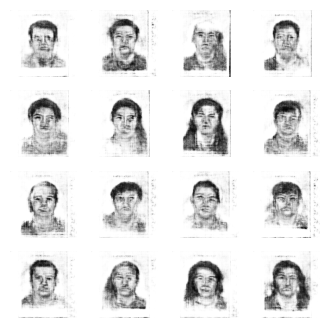

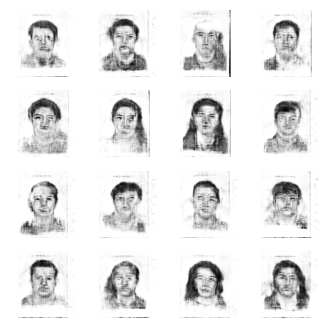

Epoch 1 done


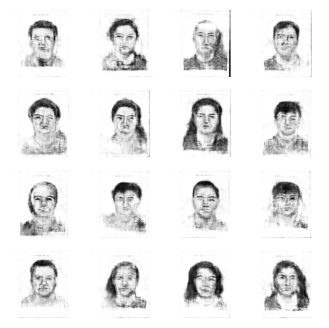

Epoch 6 done


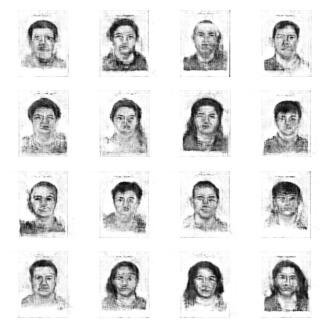

Epoch 11 done


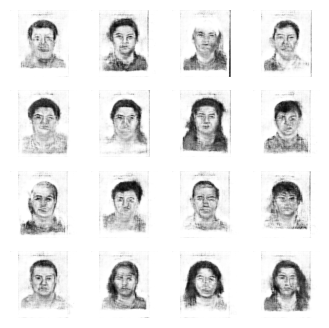

Epoch 16 done


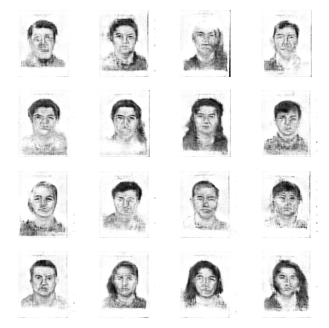

Epoch 21 done


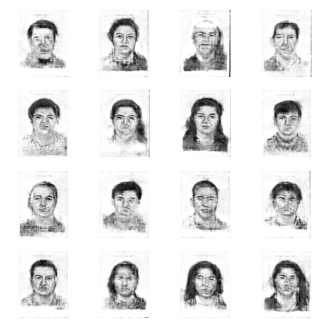

Epoch 26 done


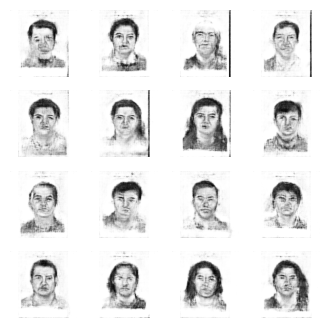

Epoch 31 done


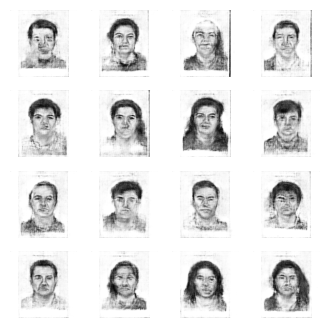

Epoch 36 done


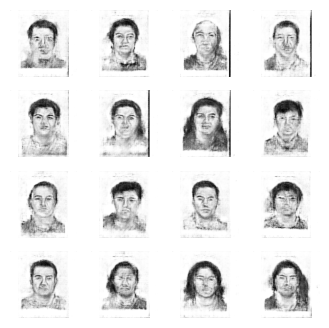

Epoch 41 done


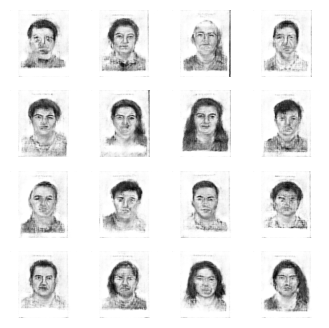

Epoch 46 done


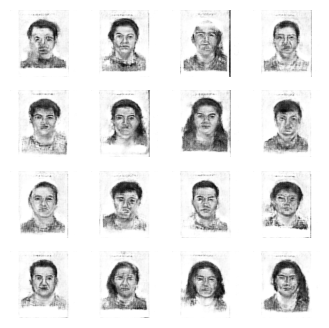

In [33]:
# Train the DCGAN
for epoch in range(epochs):
  # Loop over the batches
  for image_batch in train_dataset:
    # Train the model on the current batch
    train_step(image_batch)

# Generate and save the final images
generate_and_save_images(generator, epochs, test_input)

# Initialize lists to store the losses
gen_losses = []
disc_losses = []

for epoch in range(epochs):
  # Loop over the batches
  for image_batch in train_dataset:
    # Train the model on the current batch
    train_step(image_batch)

    # # Append the losses to the lists
    # gen_losses.append(gen_loss)
    # disc_losses.append(disc_loss)
  if epoch % 1000 == 0:
    # Generate and save images at the end of each epoch
    generate_and_save_images(generator, epoch + 1, test_input)
    # Print the current epoch
    print ('Epoch {} done'.format(epoch + 1))



# Generate and save the final images
generate_and_save_images(generator, epochs, test_input)


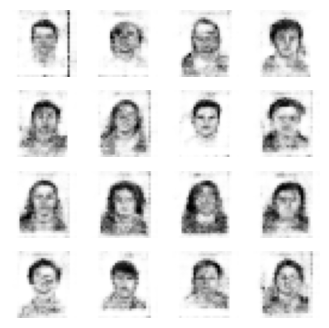

In [ ]:
# Generate 16 random vectors
random_vectors = tf.random.normal([16, latent_dim])
# Generate images from the random vectors
generated_images = generator(random_vectors, training=False)
# Plot the images in a 4x4 grid
fig = plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
  plt.subplot(4, 4, i+1)
  plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
# Show the figure
plt.show()


In [36]:
# prompt: plot the losses of generator using it's history
gn = generator.history
# plt.plot(generator.history['loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.show()


In [27]:
# Import matplotlib
import matplotlib.pyplot as plt
# Initialize empty lists to store the loss values
G_losses = []
D_losses = []
# Define the training loop
for epoch in range(epochs):
  # Loop over the batches
  for i, data in enumerate(dataloader, 0):
    # Train the model on the current batch
    # Update the generator and the discriminator
    # Compute the generator and discriminator losses
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    # Append the loss values to the lists
    G_losses.append(gen_loss.item())
    D_losses.append(disc_loss.item())
# Plot the loss values over the iterations
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


NameError: name 'dataloader' is not defined